In [1]:
library(Seurat)
library(tidyverse)
suppressPackageStartupMessages(library(ComplexHeatmap))
library(ggsci)
library(ggalluvial)
library(patchwork)
suppressPackageStartupMessages(library(clusterProfiler))
suppressPackageStartupMessages(library("org.Hs.eg.db"))

Attaching SeuratObject

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [7]:
seuratobj=readRDS('/mnt/MXMERZ002A/LargeData/seuratobj_1.rds')

In [4]:
outputfiles=list.files('/mnt/MXMERZ002A/LargeData/enclone/', pattern = 'enclone_output', full.names = T)
results_list=bind_rows(lapply(outputfiles, read_csv, show_col_types = FALSE))

In [9]:
seuratobj@meta.data=seuratobj@meta.data %>% rownames_to_column('cellbarcode2') %>% mutate(cell_barcode=str_extract(cellbarcode, '[ATCG]*-1$')) %>%
left_join(results_list %>% dplyr::select(origins_cell, barcode, t_agg_clonotype_id=group_id), by=c(orig.ident='origins_cell', cell_barcode='barcode')) %>%
column_to_rownames('cellbarcode2')

In [10]:
reducedim1=function(seuratobj_PB){
    seuratobj_PB <- FindVariableFeatures(seuratobj_PB, selection.method = "vst", nfeatures = 1000, verbose = F)
seuratobj_PB <- ScaleData(seuratobj_PB, verbose = F)
seuratobj_PB <- RunPCA(seuratobj_PB, features = VariableFeatures(object = seuratobj_PB), verbose = F)
}

In [11]:
seuratobj@meta.data=seuratobj@meta.data %>% 
mutate(timepoint=ifelse(days.since.apharesis<2, 'pre','post'))

In [12]:
seuratobj_P12=seuratobj[,seuratobj$patient==12&
                        !is.na(seuratobj$t_agg_clonotype_id)
                       ]

In [13]:
seuratobj_P12=reducedim1(seuratobj_P12)

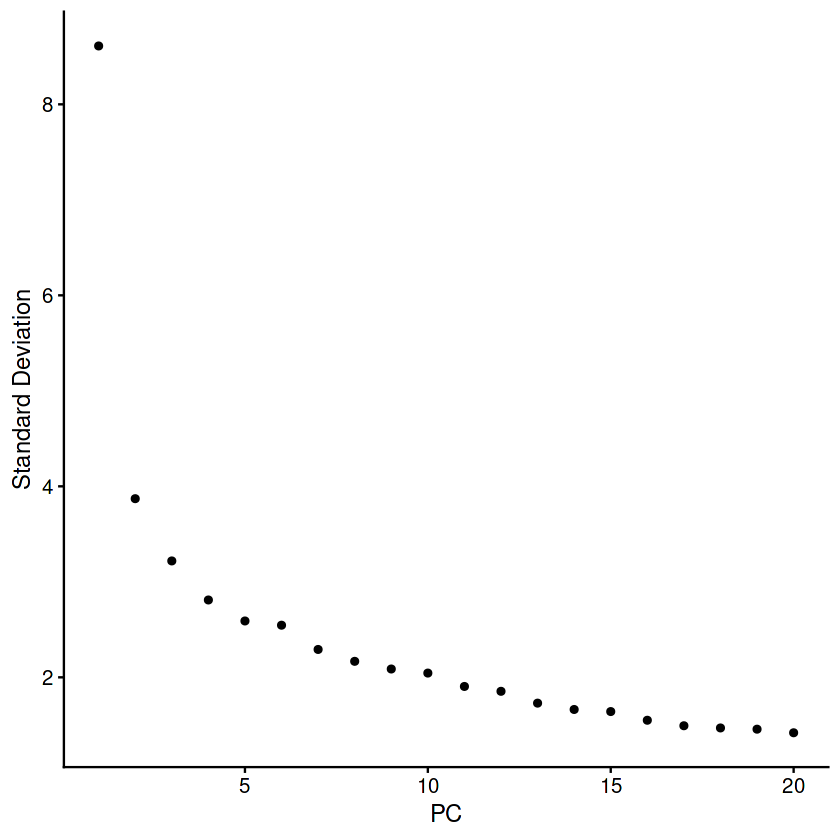

In [105]:
ElbowPlot(seuratobj_P12, ndims = 20, reduction = "pca")

In [14]:
seuratobj_P12 <- RunUMAP(seuratobj_P12, dims = 1:7, verbose = F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


Pre/post PBMC UMAP featureplot with Idecel expression and with the TCR expansion
Plots were generated for patient 12 and 14 separately. Cells were subsetted for those that were clonotyped for TCR. 
### Patient 12

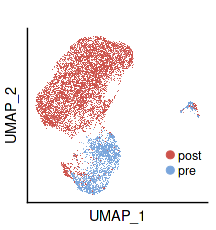

In [108]:
#Figure 6A
options(repr.plot.width=3, repr.plot.height=3.20, repr.plot.res=72)
DimPlot(seuratobj_P12, pt.size = 1, reduction = "umap", cols=pal_jco(palette = c("default"), alpha = 1)(n=10)[c(4, 5, 7)], group.by="timepoint", raster=T, shuffle =T)+
ggtitle('')+
  theme(legend.position = c(0.75, 0.25),# text = element_text(size=15), 
                plot.title = element_text(vjust = -5),
         plot.margin = margin(0,0.1,0,0, "cm"),
        axis.ticks.x=element_blank(),
       axis.ticks.y=element_blank(),
       axis.text.x=element_blank(),
       axis.text.y=element_blank(),
       legend.spacing.x = unit(0, "cm"))+
guides(colour = guide_legend(override.aes = list(size=3)))

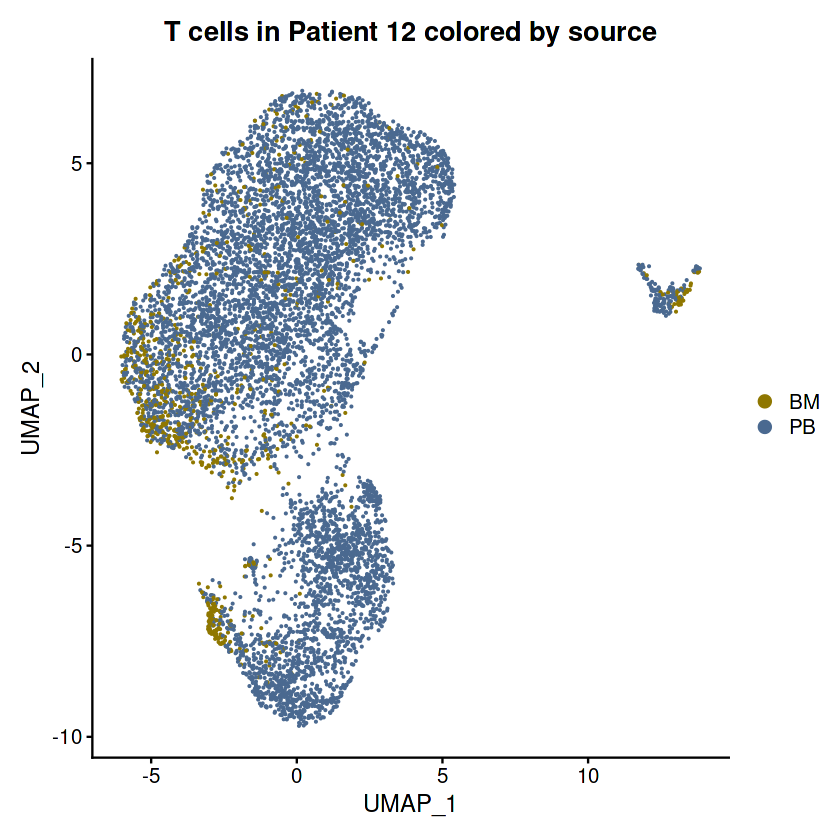

In [247]:
options(repr.plot.width=7, repr.plot.height=7)
DimPlot(seuratobj_P12, pt.size = 0.1, reduction = "umap", cols=pal_jco(palette = c("default"), alpha = 1)(n=10)[c(7, 10)], group.by="source", raster=FALSE, shuffle =T)+
ggtitle('T cells in Patient 12 colored by source')

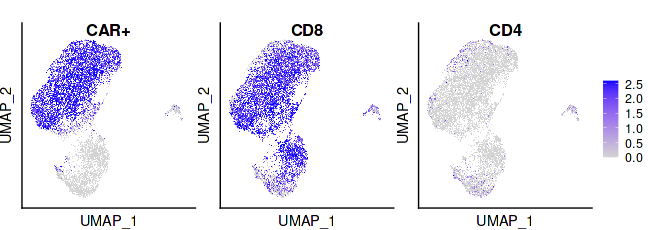

In [109]:
# Figure 6A
options(repr.plot.width=9, repr.plot.height=3.20, repr.plot.res=72)
p=FeaturePlot(seuratobj_P12, features = c("idecabtagene", "CD8A", "CD4"), raster=T, ncol=3, keep.scale='all', max.cutoff=2.6)+
  plot_layout(guides = 'collect')&
  theme(#axis.title.y = element_text(vjust = -3), 
        plot.title = element_text(vjust = -5),
     plot.margin = margin(0,0.1,0,0, "cm"),
               axis.ticks.x=element_blank(),
       axis.ticks.y=element_blank(),
       axis.text.x=element_blank(),
       axis.text.y=element_blank())
p[[1]]=p[[1]]+ggtitle('CAR+')
p[[2]]=p[[2]]+ggtitle('CD8')
p

In [235]:
seuratobj_P12@meta.data=seuratobj_P12@meta.data %>% rownames_to_column('temp') %>% 
add_count(t_agg_clonotype_id) %>%
mutate(clonalfrequency=n/n()*100) %>%
mutate(clonalsize=ifelse(clonalfrequency>0.1, 'Hyperexpanded', 
                        ifelse(clonalfrequency<=0.1&clonalfrequency>0.01, 'Large',
                               ifelse(clonalfrequency<=0.01&clonalfrequency>0.001, 'Medium',
                                      ifelse(clonalfrequency<=0.001&clonalfrequency>0, 'Small',NA))))) %>%
mutate(clonalsize=ifelse(is.na(t_agg_clonotype_id), NA, clonalsize)) %>% 
column_to_rownames('temp')

In [236]:
clonalfreq=seuratobj_P12@meta.data %>% select(t_agg_clonotype_id, n, clonalfrequency) %>% distinct

In [237]:
clonalfreq=clonalfreq %>% mutate(size=ifelse(clonalfrequency>20, 1, 
                                 ifelse(clonalfrequency>10, 2, 3)))
                                       
clonalfreq$size=as.factor(clonalfreq$size)

In [243]:
p1=ggplot(clonalfreq, aes(clonalfrequency, fill=size))+geom_histogram(bins=100, alpha=0.8)+
scale_fill_manual(values = pal_jco(palette = c("default"), alpha = 1)(n=10)[c(7, 4, 3)])+
scale_y_continuous(breaks=c(0,1,2,3,4,5,10,30,100,300,1000, 2000), trans="log1p", expand=c(0,0))+guides(fill=F)+xlab('Clone size (%)')+
    theme(text = element_text(size=14))+ggtitle('Distribution of clone size')

In [240]:
seuratobj_P12@meta.data=seuratobj_P12@meta.data %>% rownames_to_column('cellbarcode') %>% 
left_join(clonalfreq %>% select(t_agg_clonotype_id, size), by='t_agg_clonotype_id') %>%
column_to_rownames('cellbarcode')


In [244]:
p2=DimPlot(seuratobj_P12, pt.size = 0.1, reduction = "umap", cols=pal_jco(palette = c("default"), alpha = 1)(n=10)[c(7, 4, 3)], group.by="size", raster=FALSE, shuffle =T)+
ggtitle('T cells in Patient 12 colored by clonotypes')+guides(color=F)

Distribution of clonotypes. 

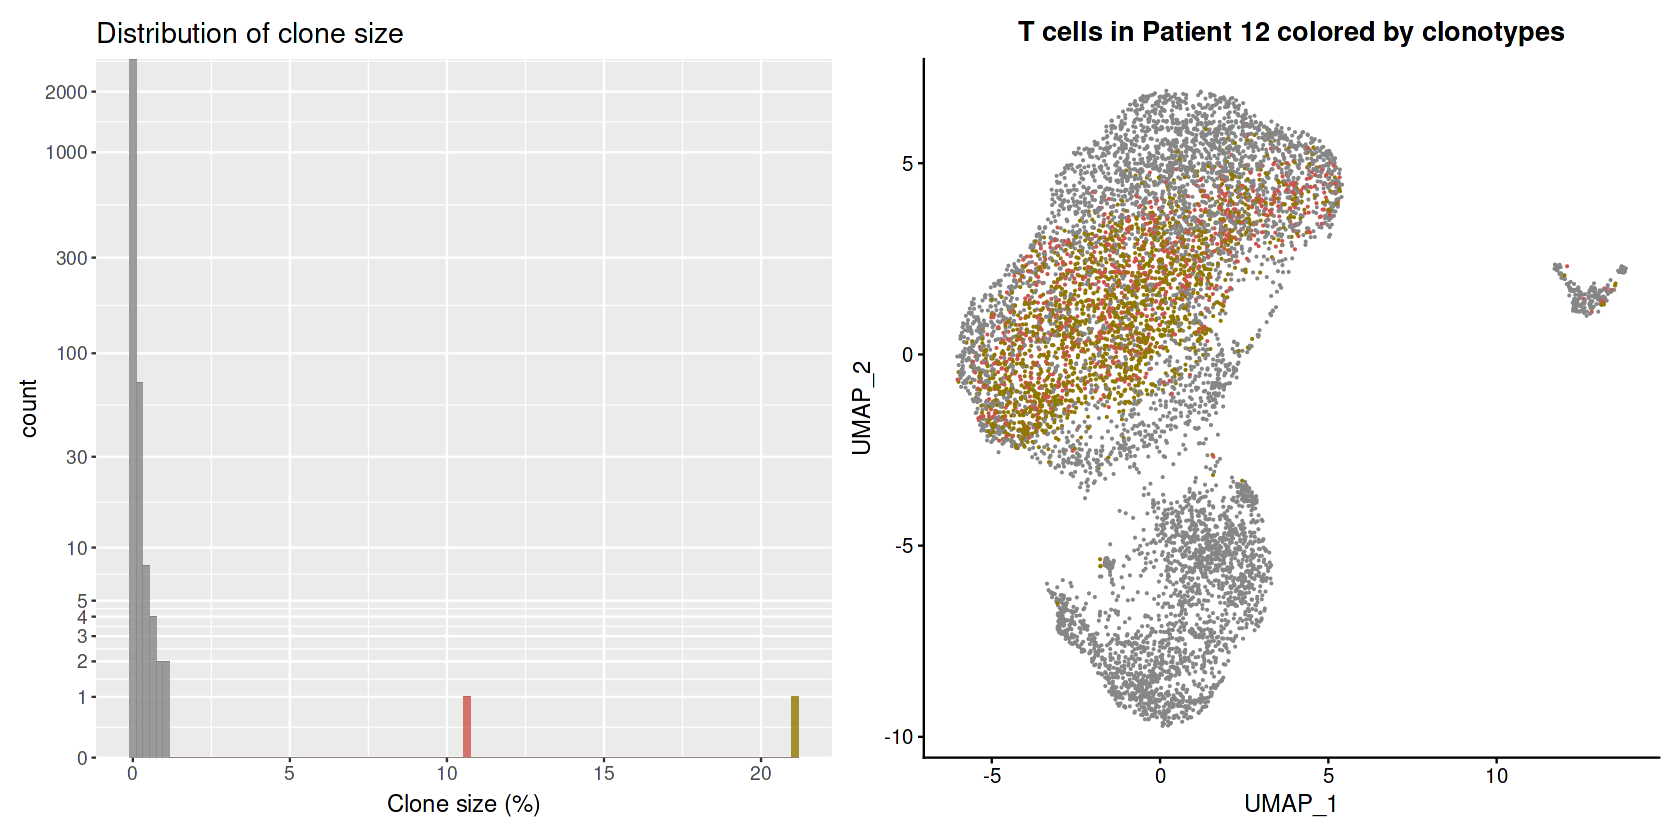

In [245]:
# Figure 6B
options(repr.plot.width=14, repr.plot.height=7)
p1+p2

### Patient 14

In [110]:
seuratobj_P14=seuratobj[,seuratobj$patient==14&
                        !is.na(seuratobj$t_agg_clonotype_id)
                       ]

In [111]:
seuratobj_P14=reducedim1(seuratobj_P14)

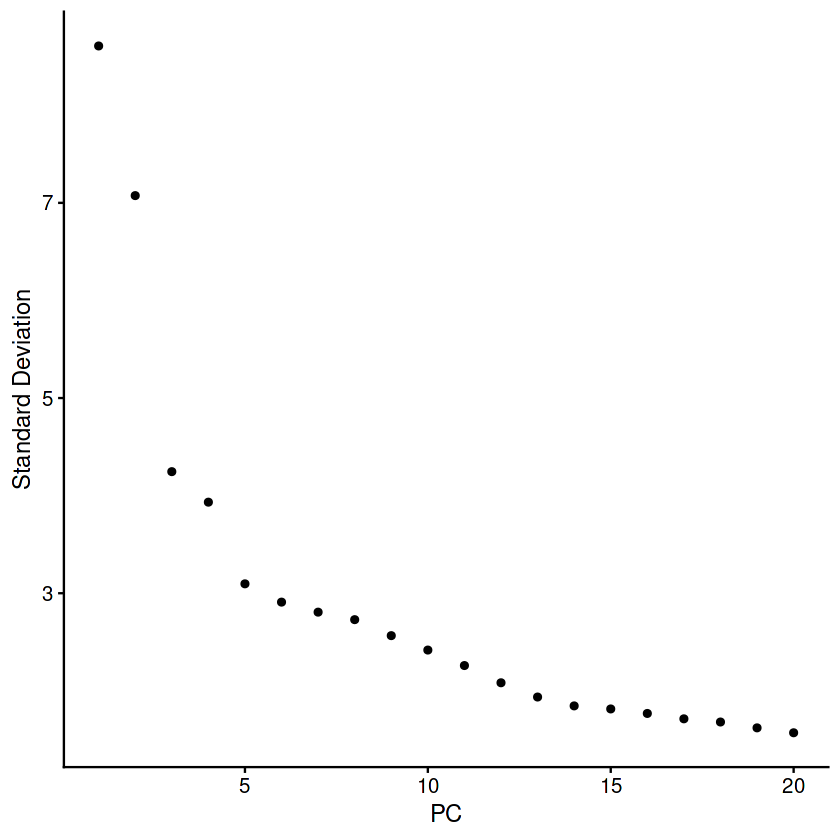

In [253]:
ElbowPlot(seuratobj_P14, ndims = 20, reduction = "pca")

In [112]:
seuratobj_P14 <- RunUMAP(seuratobj_P14, dims = 1:7, verbose = F)

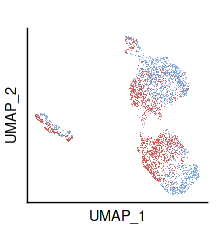

In [117]:
# Figure 6A
options(repr.plot.width=3, repr.plot.height=3.20, repr.plot.res=72)
DimPlot(seuratobj_P14, pt.size = 1, reduction = "umap", cols=pal_jco(palette = c("default"), alpha = 1)(n=10)[c(4, 5, 7)], group.by="timepoint", raster=T, shuffle =T)+
ggtitle('')+
  theme(legend.position = "none",# text = element_text(size=15), 
                plot.title = element_text(vjust = -5),
         plot.margin = margin(0,0.1,0,0, "cm"),
        axis.ticks.x=element_blank(),
       axis.ticks.y=element_blank(),
       axis.text.x=element_blank(),
       axis.text.y=element_blank(),
       legend.spacing.x = unit(0, "cm"))+
guides(colour = guide_legend(override.aes = list(size=3)))

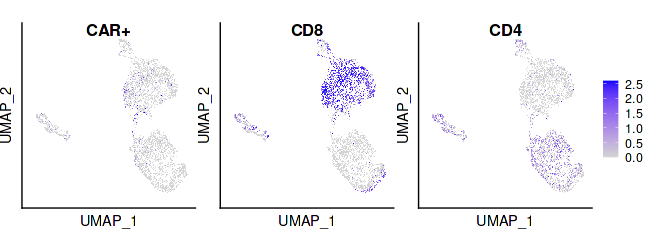

In [116]:
options(repr.plot.width=9, repr.plot.height=3.20, repr.plot.res=72)
p=FeaturePlot(seuratobj_P14, features = c("idecabtagene", "CD8A", "CD4"), raster=T, ncol=3, keep.scale='all', max.cutoff=2.6)+
  plot_layout(guides = 'collect')&
  theme(#axis.title.y = element_text(vjust = -3), 
        plot.title = element_text(vjust = -5),
     plot.margin = margin(0,0.1,0,0, "cm"),
               axis.ticks.x=element_blank(),
       axis.ticks.y=element_blank(),
       axis.text.x=element_blank(),
       axis.text.y=element_blank())
p[[1]]=p[[1]]+ggtitle('CAR+')
p[[2]]=p[[2]]+ggtitle('CD8')
p

In [257]:
seuratobj_P14@meta.data=seuratobj_P14@meta.data %>% rownames_to_column('temp') %>% 
add_count(t_agg_clonotype_id) %>%
mutate(clonalfrequency=n/n()*100) %>%
mutate(clonalsize=ifelse(clonalfrequency>0.1, 'Hyperexpanded', 
                        ifelse(clonalfrequency<=0.1&clonalfrequency>0.01, 'Large',
                               ifelse(clonalfrequency<=0.01&clonalfrequency>0.001, 'Medium',
                                      ifelse(clonalfrequency<=0.001&clonalfrequency>0, 'Small',NA))))) %>%
mutate(clonalsize=ifelse(is.na(t_agg_clonotype_id), NA, clonalsize)) %>% 
column_to_rownames('temp')

In [258]:
clonalfreq=seuratobj_P14@meta.data %>% select(t_agg_clonotype_id, n, clonalfrequency) %>% distinct

In [279]:
clonalfreq=clonalfreq %>% mutate(size=ifelse(clonalfrequency>1.5, 1, 
                                 ifelse(clonalfrequency>0.67913031	, 2, 3)))
                                       
clonalfreq$size=as.factor(clonalfreq$size)

In [280]:
p1=ggplot(clonalfreq, aes(clonalfrequency, fill=size))+geom_histogram(bins=100, alpha=0.8)+
scale_fill_manual(values = pal_jco(palette = c("default"), alpha = 1)(n=10)[c(7, 4, 3)])+
scale_y_continuous(breaks=c(0,1,2,3,4,5,10,30,100,300,1000, 2000), trans="log1p", expand=c(0,0))+guides(fill=F)+xlab('Clone size (%)')+
    theme(text = element_text(size=14))+ggtitle('Distribution of clone size')

In [276]:
seuratobj_P14@meta.data=seuratobj_P14@meta.data %>% rownames_to_column('cellbarcode') %>% select(!size) %>%
left_join(clonalfreq %>% select(t_agg_clonotype_id, size), by='t_agg_clonotype_id') %>%
column_to_rownames('cellbarcode')


In [282]:
p2=DimPlot(seuratobj_P14, pt.size = 0.5, reduction = "umap", cols=pal_jco(palette = c("default"), alpha = 1)(n=10)[c(7, 4, 3)], group.by="size", raster=FALSE, shuffle =T)+
ggtitle('T cells in Patient 12 colored by clonotypes')+guides(color=F)

Clonotype distribution

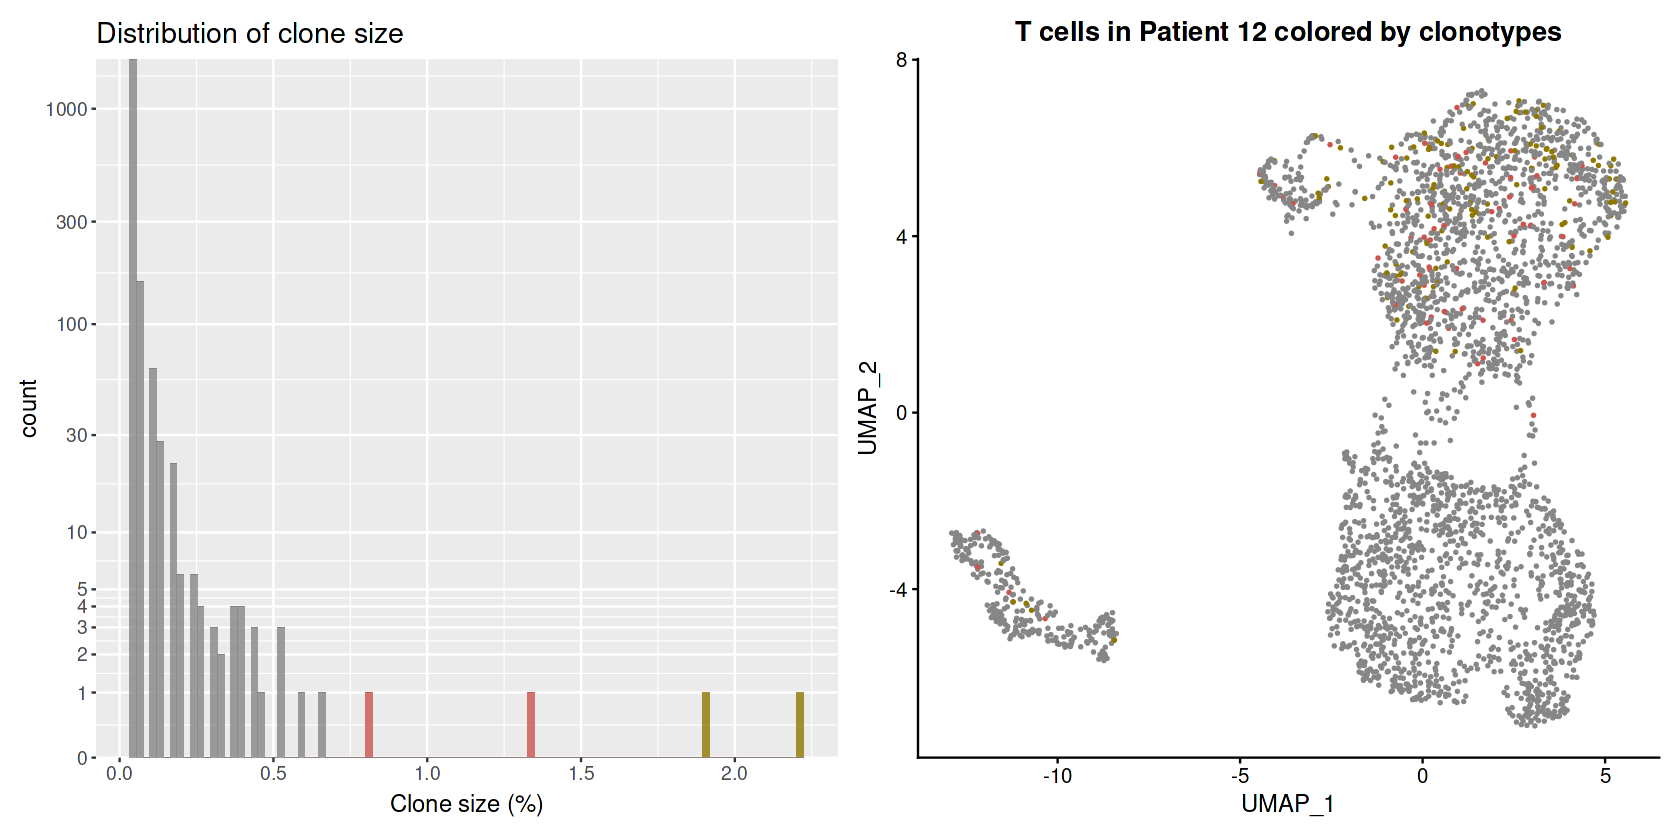

In [283]:
# Figure 6C
options(repr.plot.width=14, repr.plot.height=7)
p1+p2